# How to train a simple ridge regression model to predict antibody developability properties

### (with one hot encoded sequences)

In [74]:
# import packages
from datasets import load_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import pandas as pd

# from huggingface_hub import login
# login(token='insert_your_huggingface_token_here') # https://huggingface.co/settings/tokens/new?tokenType=read


In [75]:
# load dataset
df = load_dataset("ginkgo-datapoints/GDPa1")["train"].to_pandas()
df.head()


,antibody_id,antibody_name,Titer,Purity,SEC %Monomer,SMAC,HIC,HAC,PR_CHO,PR_Ova,...,hc_protein_sequence,hc_dna_sequence,vl_protein_sequence,lc_protein_sequence,lc_dna_sequence,hierarchical_cluster_fold,random_fold,hierarchical_cluster_IgG_isotype_stratified_fold,light_aligned_aho,heavy_aligned_aho
0,GDPa1-001,abagovomab,140.25,98.530,97.010,2.730,2.590,NaN,0.337837,0.263108,...,MRAWIFFLLCLAGRALAQVKLQESGAELARPGASVKLSCKASGYTF...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQL...,MRAWIFFLLCLAGRALADIELTQSPASLSASVGETVTITCQASENI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,1,2,2,DIELTQSPASLSASVGETVTITCQAS--ENIY------SYLAWHQQ...,QVKLQES-GAELARPGASVKLSCKASG-YTFTN-----YWMQWVKQ...
1,GDPa1-002,abituzumab,193.31,99.825,97.620,2.745,2.545,3.690,0.205246,0.100155,...,MRAWIFFLLCLAGRALAQVQLQQSGGELAKPGASVKVSCKASGYTF...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCRASQDI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,1,4,0,DIQMTQSPSSLSASVGDRVTITCRAS--QDIS------NYLAWYQQ...,QVQLQQS-GGELAKPGASVKVSCKASG-YTFSS-----FWMHWVRQ...
2,GDPa1-003,abrezekimab,114.75,98.350,89.055,2.740,2.705,NaN,0.138773,0.101180,...,MRAWIFFLLCLAGRALAQVTLKESGPVLVKPTETLTLTCTVSGFSL...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSLSASVGDRVTITCLASEDISNYLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCLASEDI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,2,2,2,DIQMTQSPSSLSASVGDRVTITCLAS--EDIS------NYLAWYQQ...,QVTLKES-GPVLVKPTETLTLTCTVSG-FSLTN-----YHVQWIRQ...
3,GDPa1-004,abrilumab,327.32,98.575,98.605,2.715,2.565,1.005,0.000000,0.054971,...,MRAWIFFLLCLAGRALAQVQLVQSGAEVKKPGASVKVSCKVSGYTL...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSVSASVGDRVTITCRASQGISSWLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSVSASVGDRVTITCRASQGI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,1,3,0,DIQMTQSPSSVSASVGDRVTITCRAS--QGIS------SWLAWYQQ...,QVQLVQS-GAEVKKPGASVKVSCKVSG-YTLSD-----LSIHWVRQ...
4,GDPa1-005,adalimumab,313.39,99.300,96.120,2.705,2.495,NaN,0.183387,0.085628,...,MRAWIFFLLCLAGRALAEVQLVESGGGLVQPGRSLRLSCAASGFTF...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKL...,MRAWIFFLLCLAGRALADIQMTQSPSSLSASVGDRVTITCRASQGI...,GCCGCCACCATGAGAGCCTGGATCTTTTTCCTGCTGTGCCTGGCTG...,0,2,0,DIQMTQSPSSLSASVGDRVTITCRAS--QGIR------NYLAWYQQ...,EVQLVES-GGGLVQPGRSLRLSCAASG-FTFDD-----YAMHWVRQ...


## Quick Primer
### Antibody Sequences: VH and VL
Antibodies are Y-shaped proteins built from two chains:
- **VH (Variable Heavy)**: the heavy-chain variable region that contributes to antigen binding.  
- **VL (Variable Light)**: the light-chain variable region that pairs with VH to form the complete binding site.  

Together, VH and VL encode the amino acid sequences that define an antibody’s specificity and biochemical properties.  
In this dataset, each row includes both VH and VL sequences for a given antibody.  


![image/png](https://cdn-uploads.huggingface.co/production/uploads/66df5f0644a0a0d033c50463/PIjgj1bK2YxyIZ1rj1M8S.png)
*Image from https://www.antibody-creativebiolabs.com/antibody-structure-isotypes.htm*

### Available Properties

Each antibody has associated experimental measurements across 5 assays (not all measurements are available for every sequence):

- **Titer**: Expression yield of the antibody in mammalian cells.  
- **HIC** (*Hydrophobic Interaction Chromatography*): A proxy for hydrophobicity and aggregation propensity.  
- **PR_CHO**: Polyreactivity in CHO (*Chinese hamster ovary*) cells - this measures how much an antibody binds to other proteins that it's not supposed to.
- **Tm2**: Thermal stability (melting temperature of the CH2 domain).  
- **AC-SINS_pH7.4**: Self-interaction propensity (higher values often correlate with poor developability).


In [76]:
# Show number of NaNs per assay
print(df[["Titer", "HIC", "PR_CHO", "Tm2", 'AC-SINS_pH7.4']].isna().sum())
target = "HIC"

# Example: Just predict HIC, so we'll drop NaN rows for that
df = df.dropna(subset=[target])

Titer             7
HIC               4
PR_CHO           49
Tm2              53
AC-SINS_pH7.4     4
dtype: int64


In [77]:
# One-hot sequence preparation
# note: Ridge regression model requires inputs to be the same length. We are using aligned heavy and light chains numbered with AHo

# we have a 21 token dictionary: 20 aa's and 1 gap token '-'
VOCAB = list("ACDEFGHIKLMNPQRSTVWY-")

# Concatenate heavy + light chain sequences (no separator for this simple model)
combined = [f"{vh}{vl}" for vh, vl in zip(df["heavy_aligned_aho"], df["light_aligned_aho"])]

# Split each sequence into a list of amino acids
split = [list(seq) for seq in combined]
seq_len = len(split[0])
print(f"Total concatenated sequence length: {seq_len}")

# Sanity check: ensure all sequences have identical length. Ridge regression moel requires this
if not all(len(s) == seq_len for s in split):
    raise ValueError("All concatenated VH+VL sequences must have the same length.")

# Create a DataFrame with one column per residue position
df_split = pd.DataFrame(split, columns=[f"pos_{i}" for i in range(seq_len)])
print(f"Feature DataFrame shape before encoding: {df_split.shape}")

# Define the amino acid alphabet (21 characters including '-')
fixed_categories = [VOCAB] * seq_len

# Initialize the one-hot encoder
encoder = ColumnTransformer([
    ("onehot", OneHotEncoder(
        categories=fixed_categories,
        handle_unknown="ignore",
        sparse_output=False
    ), df_split.columns.tolist())
])
print("Initialized OneHotEncoder with fixed amino acid categories.")

# Fit and transform sequences into one-hot encoded array
X = encoder.fit_transform(df_split)
print(f"One-hot feature matrix shape: {X.shape}")


Total concatenated sequence length: 298
Feature DataFrame shape before encoding: (242, 298)
Initialized OneHotEncoder with fixed amino acid categories.
One-hot feature matrix shape: (242, 6258)


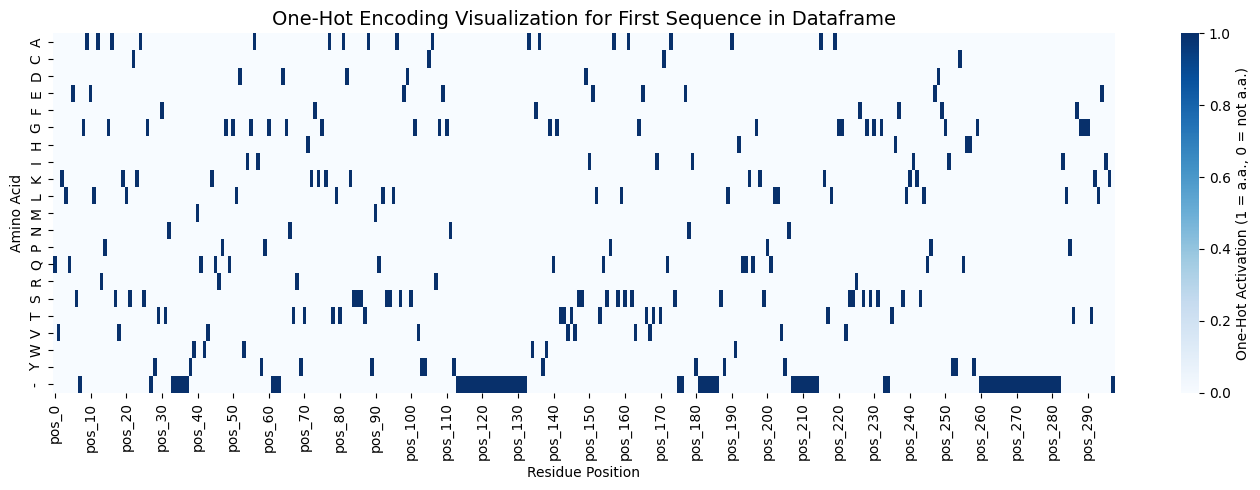

In [78]:
# Here I show a visualization of the onehot encoding for the first sequence in the dataframe

# Select the first sequence
i = 0
seq = combined[i]

# Extract one-hot rows corresponding to this sequence
X_single = X[i].reshape(seq_len, len(VOCAB))

# Create a DataFrame for readability
onehot_df = pd.DataFrame(X_single, columns=VOCAB)
onehot_df.index = [f"pos_{i}" for i in range(seq_len)]

# Plot heatmap visualization with legend
plt.figure(figsize=(14, 5))
ax = sns.heatmap(
    onehot_df.T,
    cmap="Blues",
    cbar=True,
    cbar_kws={"label": "One-Hot Activation (1 = a.a., 0 = not a.a.)"},
    xticklabels=10,
    yticklabels=VOCAB,
)

plt.title("One-Hot Encoding Visualization for First Sequence in Dataframe", fontsize=14)
plt.xlabel("Residue Position")
plt.ylabel("Amino Acid")

plt.tight_layout()
plt.show()


In [79]:
# Train Ridge regression on one-hot encoded VH/VL sequences

# Split into training and test sets
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize Ridge regression model
lm = Ridge(alpha=1.0, random_state=42)

# Fit the model
print(f"[TRAIN] Fitting Ridge regression for '{target}'...")
lm.fit(X_train, y_train)

# Predict on test set
y_pred = lm.predict(X_test)


[TRAIN] Fitting Ridge regression for 'HIC'...


SignificanceResult(statistic=np.float64(0.559363128005977), pvalue=np.float64(2.939882972523167e-05))


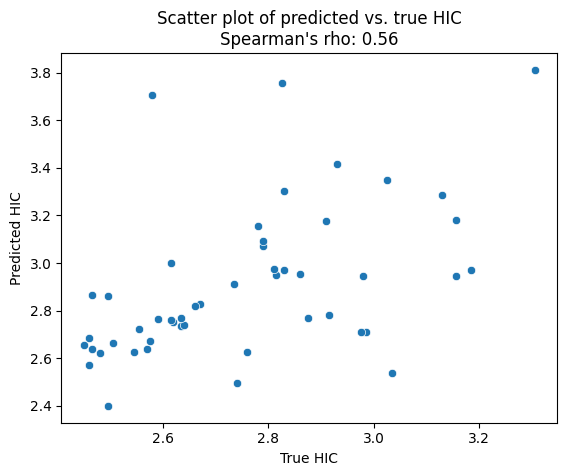

In [80]:
# Calculate score
print(spearmanr(y_pred, y_test))

sns.scatterplot(x=y_test, y=y_pred)
plt.title(f"Scatter plot of predicted vs. true {target}\nSpearman's rho: {spearmanr(y_pred, y_test)[0]:.2f}")
plt.xlabel(f"True {target}")
plt.ylabel(f"Predicted {target}")
plt.show()


We evaluate the model using **Spearman’s rank correlation** between predicted and true assay values, which is more robust than linear correlation when the relationship is non-linear. Finally, we visualize predictions against ground truth in a scatter plot to assess how well the model generalizes. 

We get approximately `0.56` Spearman correlation using one hot encoded sequences with linear regression to predict `HIC`.

### Ridge Regression Offers Interpretability

A major advantage of the ridge regression model in protein sequence analysis is its **direct interpretability**.  
Because each feature corresponds to a specific amino acid at a specific residue position (via one-hot encoding), every learned coefficient has a clear biological meaning:

- **Positive coefficients** indicate amino acids that increase the target property (e.g., binding affinity or stability) when present at that position.  
- **Negative coefficients** indicate amino acids that decrease the property.  
- **Magnitude** reflects the relative importance or sensitivity of that site to substitution.

This transparency allows researchers to **map model weights back to sequence positions** and visualize them, as in the heatmap below.  

### Limitations of Ridge Regression for Protein Sequence Modeling

While ridge regression provides interpretability, it comes with notable limitations when applied to protein design tasks:

- **Linear Assumptions:** Ridge regression models only capture *linear relationships* between features and the target property. Complex nonlinear effects cannot be learned directly.
- **Positional Extrapolation Constraints:** Ridge regression assigns weights of zero to unobserved amino acids at a given position. In practice, if only one amino acid is present in the training data at a specific site, the model cannot infer the impact of substitutions at that position. As a result, it effectively treats those positions as neutral during prediction.









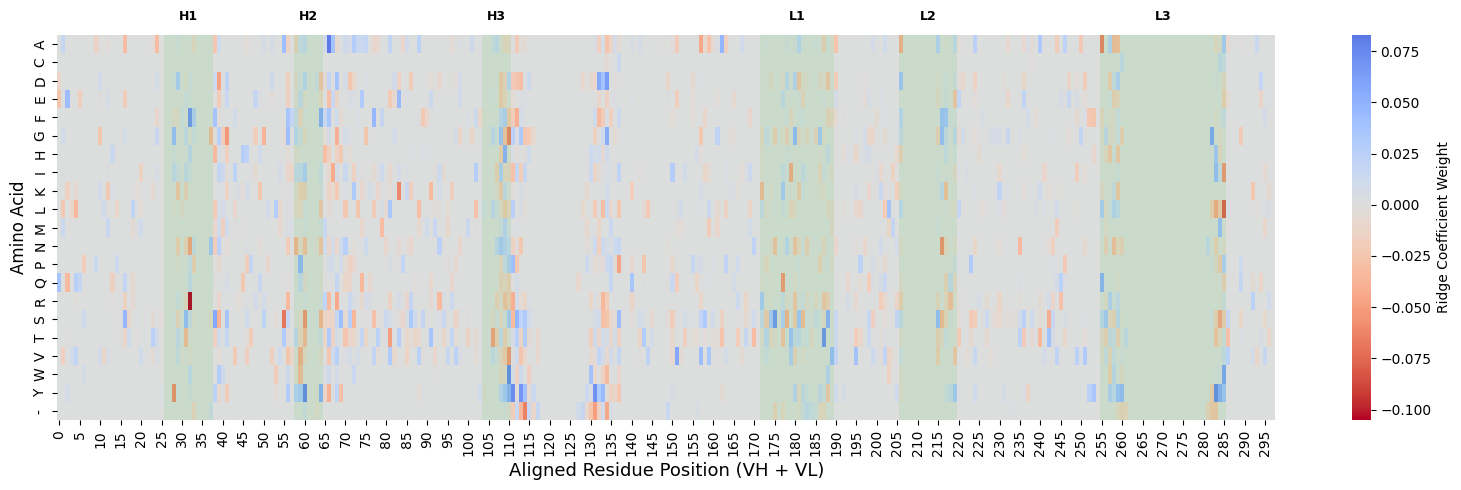

In [81]:
# Create amino acid weight matrix for visualization

# Compute coefficient heatmap with CDR overlays (handles gaps in aligned sequences)
coef = lm.coef_.ravel()
seq_len = len(df_split.columns)  # total aligned positions
vocab_size = len(VOCAB)          # 21 amino acids + gap

coef_matrix = coef.reshape(seq_len, vocab_size)
coef_df = pd.DataFrame(coef_matrix.T, index=VOCAB, columns=[f"{i}" for i in range(seq_len)])

# --- Define CDR residue spans by AHo numbering ---
cdr_aho_H = {"H1": (26, 32), "H2": (52, 56), "H3": (95, 102)}
cdr_aho_L = {"L1": (24, 34), "L2": (50, 56), "L3": (89, 97)}

# --- Map AHo residue numbers to aligned indices (handle gaps) ---
heavy_seq = df["heavy_aligned_aho"].iloc[0]
light_seq = df["light_aligned_aho"].iloc[0]
offset_L = len(heavy_seq)  # offset where light chain starts

def aho_to_aligned_indices(aligned_seq, start_aho, end_aho):
    """Map AHo numbering to aligned indices, skipping gaps."""
    indices = []
    counter = 0
    for i, aa in enumerate(aligned_seq):
        if aa != "-":
            counter += 1
        if start_aho <= counter <= end_aho:
            indices.append(i)
    if indices:
        return (indices[0], indices[-1])
    else:
        return None

# Map heavy and light chain CDRs to alignment coordinates
cdr_ranges_all = {}
for name, (s, e) in cdr_aho_H.items():
    mapped = aho_to_aligned_indices(heavy_seq, s, e)
    if mapped:
        cdr_ranges_all[name] = mapped

for name, (s, e) in cdr_aho_L.items():
    mapped = aho_to_aligned_indices(light_seq, s, e)
    if mapped:
        # add offset for light chain
        cdr_ranges_all[name] = (mapped[0] + offset_L, mapped[1] + offset_L)

# ----------------------------------------------------------
# Plot amino acid weight heatmap with CDR highlights
# ----------------------------------------------------------
plt.figure(figsize=(16, 5))
ax = sns.heatmap(
    coef_df,
    cmap="coolwarm_r",
    center=0,
    linewidths=0.0,
    cbar_kws={"label": "Ridge Coefficient Weight"},
)

plt.xlabel("Aligned Residue Position (VH + VL)", fontsize=13)
plt.ylabel("Amino Acid", fontsize=12)

# Overlay CDRs
for name, (start, end) in cdr_ranges_all.items():
    ax.axvspan(start, end, color="limegreen", alpha=0.1, lw=0)
    ax.text(
        (start + end) / 2,
        -1,
        name,
        ha="center",
        va="center",
        fontsize=9,
        color="black",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()


### Interpreting Ridge Regression Coefficients Across Aligned Antibody Positions

The heatmap above visualizes the **Ridge regression coefficient weights** assigned to each amino acid at every aligned residue position in the concatenated heavy (VH) and light (VL) chains. Each cell represents how strongly the presence of a given amino acid influences the target property (e.g., binding affinity), with:

- **Red shades** indicating a *negative contribution* (amino acid substitutions that decrease the predicted property).
- **Blue shades** indicating a *positive contribution* (amino acids that increase the predicted property).
- **Gray or white areas** reflecting residues with little to no effect (weights near zero).

#### CDR Annotations
The vertical green bands highlight the **Complementarity-Determining Regions (CDRs)** — the loops that primarily determine antigen binding:

- **H1, H2, H3:** Heavy-chain CDRs  
- **L1, L2, L3:** Light-chain CDRs  

We can compare the magnitude of weights in the cdr and framework regions to interpret where the strongest linear effects are in the data for predicting our desired target value (HIC in this case).

In summary, this plot captures how the linear ridge regression model learns interpretable residue-level preferences, highlighting **which positions and amino acid substitutions most strongly influence** the model’s predictions.


## Cross-Validation with Isotype-Stratified Folds

In our previous experiment, we allowed the training and test sets to be randomly generated. The problem with this is that there may be near-identical antibodies split between training and test, essentially creating label leakage. To understand how our model behaves when presented with totally new antibodies, we want to evaluate our regressor with **cluster + isotype-aware
cross-validation**.

Each fold holds out **entire sequence clusters (but still containing a mix of different IgG subclasses)**, so the model is tested on *novel* families rather than near-duplicates. Below, we reuse the previously computed embeddings and our target `y`, but we use the pre-computed fold assignment in `df['hierarchical_cluster_IgG_isotype_stratified_fold']` to define train/test splits. Now, we train fresh `Ridge` models on each training split and evaluate with Spearman correlation on the held-out fold.

Averaged CV Spearman:	0.2201


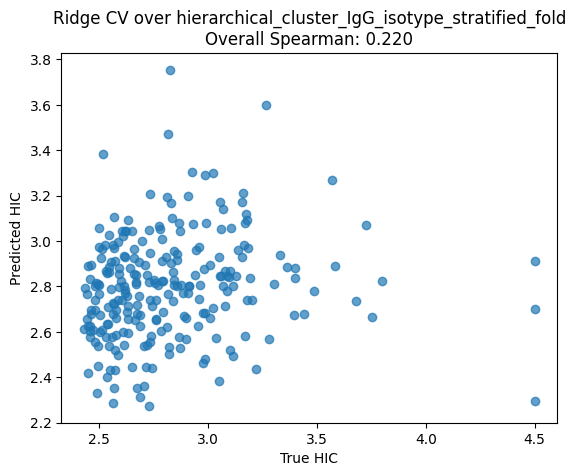

In [82]:
fold_col = "hierarchical_cluster_IgG_isotype_stratified_fold"

# sanity check
assert len(X) == len(df) == len(y)

fold_values = df[fold_col].to_numpy()
unique_folds = [f for f in np.unique(fold_values) if f == f]  # drop NaN

per_fold_stats = []
y_pred_all = np.full(len(df), np.nan)   # align with df rows
y_true_all = np.full(len(df), np.nan)   # optional, for plotting/metrics

for f in unique_folds:
    test_idx = np.where(fold_values == f)[0]
    train_idx = np.where(fold_values != f)[0]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    lm = Ridge()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)

    # write back into the positions of df
    y_pred_all[test_idx] = y_pred
    y_true_all[test_idx] = y_test

    rho = spearmanr(y_test, y_pred).statistic
    per_fold_stats.append((int(f), rho, len(y_test)))

# Overall metric across all rows that participated in CV
mask = ~np.isnan(y_true_all)
overall_rho = spearmanr(y_true_all[mask], y_pred_all[mask]).statistic

print(f"Averaged CV Spearman:\t{overall_rho:.4f}")

plt.figure()
plt.scatter(y_true_all[mask], y_pred_all[mask], alpha=0.7)
plt.title(f"Ridge CV over {fold_col}\nOverall Spearman: {overall_rho:.3f}")
plt.xlabel(f"True {target}")
plt.ylabel(f"Predicted {target}")
plt.show()


This gives us a Spearman correlation of about `0.220` for predicting `HIC` with a ridge regression model - lower than when we used the random split, but this gives us a *more realistic* estimate of how well our model will generalize to new antibodies in the test set.

Now, to submit these predictions to the leaderboard, we write out to CSV:


In [83]:
GDPa_submission_CV  =  df[['antibody_name', 'vh_protein_sequence', 'vl_protein_sequence', 'hierarchical_cluster_IgG_isotype_stratified_fold']].copy()
GDPa_submission_CV[target] =  y_pred_all
GDPa_submission_CV.to_csv('gpda_cv_submission.csv', index=False)


## Using the model to submit test set predictions

Finally, we'd like to use this model to submit predictions on the test set. You can download the test set from the leaderboard and make embeddings as we did before:

In [84]:
# load from csv
testset_df  =  pd.read_pickle('../data/heldout-set-sequences.pkl')

# Concatenate heavy + light chain sequences (no separator for this simple model)
combined = [f"{vh}{vl}" for vh, vl in zip(testset_df["heavy_aligned_aho"], testset_df["light_aligned_aho"])]

# Split each sequence into a list of amino acids
split = [list(seq) for seq in combined]
seq_len = len(split[0])
print(f"Total concatenated sequence length: {seq_len}")

# Sanity check: ensure all sequences have identical length. Ridge regression moel requires this
if not all(len(s) == seq_len for s in split):
    raise ValueError("All concatenated VH+VL sequences must have the same length.")

# Create a DataFrame with one column per residue position
df_split = pd.DataFrame(split, columns=[f"pos_{i}" for i in range(seq_len)])
print(f"Feature DataFrame shape before encoding: {df_split.shape}")

# Define the amino acid alphabet (21 characters including '-')
fixed_categories = [VOCAB] * seq_len

# Initialize the one-hot encoder
encoder = ColumnTransformer([
    ("onehot", OneHotEncoder(
        categories=fixed_categories,
        handle_unknown="ignore",
        sparse_output=False
    ), df_split.columns.tolist())
])
print("Initialized OneHotEncoder with fixed amino acid categories.")

# Fit and transform sequences into one-hot encoded array
X_test = encoder.fit_transform(df_split)
print(f"One-hot feature matrix shape: {X.shape}")



Total concatenated sequence length: 298
Feature DataFrame shape before encoding: (80, 298)
Initialized OneHotEncoder with fixed amino acid categories.
One-hot feature matrix shape: (242, 6258)


In [85]:
testset_y  =  lm.predict(X_test)

testset_submission  =  testset_df[['antibody_name', 'vh_protein_sequence', 'vl_protein_sequence']].copy()

testset_submission[target] =  testset_y

testset_submission.to_csv('testset_submission.csv', index=False)
